In [5]:
import pandas as pd
import numpy as np
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [7]:
movies = pd.read_csv(r"archive\tmdb_5000_movies.csv")
credits = pd.read_csv(r"archive\tmdb_5000_credits.csv")


In [8]:
movies = movies.merge(credits, on='title')
movies.shape



(4809, 23)

In [9]:
movies.info()
movies.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                       0
crew                       0
dtype: int64

In [10]:
def convert(text):
    return [i['name'] for i in ast.literal_eval(text)]

def get_top_cast(text):
    cast_list = []
    for i in ast.literal_eval(text):
        cast_list.append(i['name'])
        if len(cast_list) == 3:
            break
    return cast_list

def get_director(text):
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            return i['name']
    return ""


In [11]:
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(get_top_cast)
movies['crew'] = movies['crew'].apply(get_director)

movies = movies.dropna(subset=['overview'])


In [12]:
movies['tags'] = movies['overview'] + " " + \
                 movies['genres'].apply(lambda x: " ".join(x)) + " " + \
                 movies['keywords'].apply(lambda x: " ".join(x)) + " " + \
                 movies['cast'].apply(lambda x: " ".join(x)) + " " + \
                 movies['crew']

movies['tags'] = movies['tags'].apply(lambda x: x.lower())

final_df = movies[['title', 'tags']]
final_df.head()


,title,tags
0,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,Spectre,a cryptic message from bond’s past sends him o...
3,The Dark Knight Rises,following the death of district attorney harve...
4,John Carter,"john carter is a war-weary, former military ca..."


In [13]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
vectors = tfidf.fit_transform(final_df['tags']).toarray()


In [14]:
similarity = cosine_similarity(vectors)


In [19]:
print("Total movies:", movies.shape[0])


Total movies: 4806


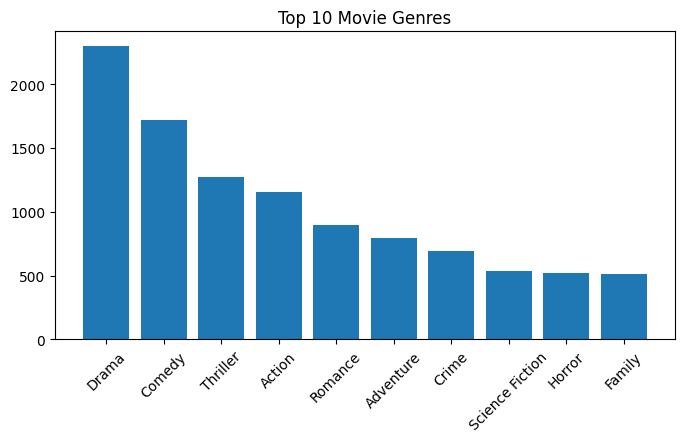

In [20]:
from collections import Counter
import matplotlib.pyplot as plt

all_genres = []
for genre_list in movies['genres']:
    all_genres.extend(genre_list)

genre_counts = Counter(all_genres).most_common(10)

genres, counts = zip(*genre_counts)

plt.figure(figsize=(8,4))
plt.bar(genres, counts)
plt.xticks(rotation=45)
plt.title("Top 10 Movie Genres")
plt.show()


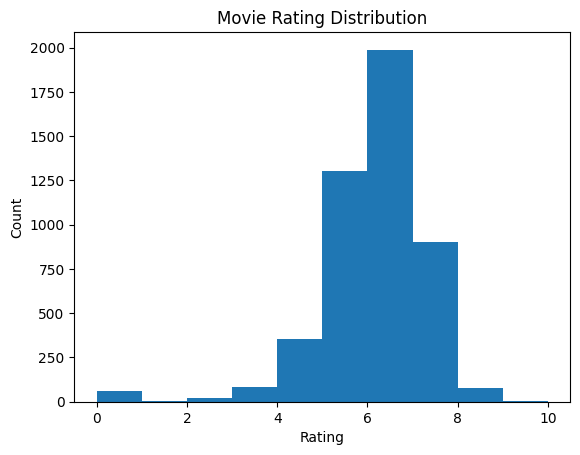

In [22]:
plt.hist(movies['vote_average'], bins=10)
plt.title("Movie Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [15]:
def recommend(movie_name):
    if movie_name not in final_df['title'].values:
        return "❌ Movie not found in dataset"

    index = final_df[final_df['title'] == movie_name].index[0]
    distances = list(enumerate(similarity[index]))
    movies_list = sorted(distances, reverse=True, key=lambda x: x[1])[1:6]

    return [final_df.iloc[i[0]].title for i in movies_list]


In [16]:
recommend("Avatar")


['Aliens', 'Alien', 'Moonraker', 'Alien³', 'Silent Running']

In [17]:
recommend("Inception")


['Hesher', 'Don Jon', 'Cypher', '(500) Days of Summer', 'The Helix... Loaded']

In [18]:
recommend("The Dark Knight")



['The Dark Knight Rises',
 'Batman Begins',
 'Batman Returns',
 'Batman Forever',
 'Batman v Superman: Dawn of Justice']

In [3]:
def recommend(movie_name):
    if movie_name not in final_df['title'].values:
        return "❌ Movie not found in dataset"

    index = final_df[final_df['title'] == movie_name].index[0]
    distances = list(enumerate(similarity[index]))
    movies_list = sorted(distances, reverse=True, key=lambda x: x[1])[1:6]

    recommendations = []
    for i in movies_list:
        recommendations.append(final_df.iloc[i[0]].title)

    return recommendations
